# Adding Multiple Wells

This notebook shows how a WellModel can be used to fit multiple wells with one response function. The influence of the individual wells is scaled by the distance to the observation point. 

*Developed by R.C. Caljé, (Artesia Water 2020), D.A. Brakenhoff, (Artesia Water 2019), and R.A. Collenteur, (Artesia Water 2018)*

In [1]:
import numpy as np
import pandas as pd
import pastas as ps
import matplotlib.pyplot as plt

ps.show_versions()

Python version: 3.8.2 (default, Mar 25 2020, 11:22:43) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
Numpy version: 1.19.2
Scipy version: 1.6.0
Pandas version: 1.2.1
Pastas version: 0.17.0b
Matplotlib version: 3.3.2


## Load data from a Menyanthes file
Menyanthes is timeseries analysis software used by many people in the Netherlands. In this example a Menyanthes-file with one observation-series is imported, and simulated. There are several stresses in the Menyanthes-file, among which are three groundwater extractions with a significant influence on groundwater head.

Import the Menyanthes-file with observations and stresses.

In [2]:
fname = '../data/MenyanthesTest.men'
meny = ps.read.MenyData(fname)

Get the distances of the extractions to the observation well. Extraction 1 is about two times as far from the observation well as extraction 2 and 3. We will use this information later in our WellModel.

In [3]:
# Get distances from metadata
xo = meny.H["Obsevation well"]['xcoord']
yo = meny.H["Obsevation well"]['ycoord']
distances = []
extraction_names = ['Extraction 2', 'Extraction 3']
for extr in extraction_names:
    xw = meny.IN[extr]["xcoord"]
    yw = meny.IN[extr]["ycoord"]
    distances.append(np.sqrt((xo-xw)**2 + (yo-yw)**2))
extraction_names = [name.replace(" ", "_") for name in extraction_names]  # replace spaces in names for Pastas
df = pd.DataFrame(distances, index=extraction_names, columns=['Distance to observation well'])
df

,Distance to observation well
Extraction_2,2281.964490
Extraction_3,2783.783397


Then plot the observations, together with the diferent stresses in the Menyanthes file.

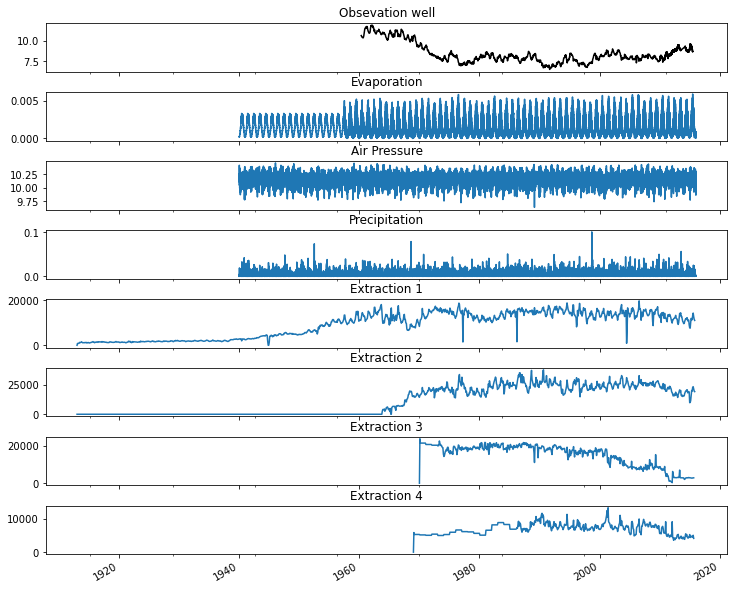

In [4]:
# plot timeseries
f1, axarr = plt.subplots(len(meny.IN)+1, sharex=True, figsize=(10,8))
oseries = meny.H['Obsevation well']["values"]
oseries.plot(ax=axarr[0], color='k')
axarr[0].set_title(meny.H['Obsevation well']["Name"])
for i, (name, data) in enumerate(meny.IN.items(), start=1):
    data["values"].plot(ax=axarr[i])
    axarr[i].set_title(name)
plt.tight_layout(pad=0)

## Create a model with a separate StressModel for each extraction

First we create a model with a separate StressModel for each groundwater extraction. First we create a model with the heads timeseries and add recharge as a stress.

In [5]:
oseries = ps.TimeSeries(meny.H['Obsevation well']['values'].dropna(), name="heads", settings="oseries")

# create model
ml = ps.Model(oseries)

INFO: Cannot determine frequency of series heads: freq=None. The time series is irregular.


Get the precipitation and evaporation timeseries and round the index to remove the hours from the timestamps.

In [6]:
prec = meny.IN['Precipitation']['values']
prec.index = prec.index.round("D")
prec.name = "prec"
evap = meny.IN['Evaporation']['values']
evap.index = evap.index.round("D")
evap.name = "evap"

Create a recharge stressmodel and add to the model.

In [7]:
rm = ps.RechargeModel(prec, evap, ps.Exponential, 'Recharge')
ml.add_stressmodel(rm)

INFO: Inferred frequency for time series prec: freq=D
INFO: Inferred frequency for time series evap: freq=D


Get the extraction timeseries.

In [8]:
stresses = []

for name in extraction_names:
    # get extraction timeseries
    s = meny.IN[name.replace("_", " ")]['values']
    
    # convert index to end-of-month timeseries
    s.index = s.index.to_period("M").to_timestamp("M")
    
    # resample to daily values
    s_daily = ps.utils.timestep_weighted_resample_fast(s, "D")
    
    # create pastas.TimeSeries object
    stress = ps.TimeSeries(s_daily.dropna(), name=name, settings="well")
    
    # append to stresses list
    stresses.append(stress)

INFO: Inferred frequency for time series Extraction_2: freq=D
INFO: Inferred frequency for time series Extraction_3: freq=D


Add each of the extractions as a separate StressModel.

In [9]:
for stress in stresses:
    sm = ps.StressModel(stress, ps.Hantush, stress.name, up=False)
    ml.add_stressmodel(sm)

Solve the model. 

Note the use of `ps.LmfitSolve`. This is because of [an issue concerning optimization with small parameter values](https://github.com/pastas/pastas/issues/177) in `scipy.least_squares`. This is something that may influence models containing a WellModel (which we will be creating later) and since we want to keep the models in this Notebook as similar as possible, we're also using `ps.LmfitSolve` here.

In [10]:
ml.solve(solver=ps.LmfitSolve)

INFO: Time Series Extraction_3 was extended to 1950-05-01 00:00:00 by adding 0.0 values.
INFO: There are observations between the simulation timesteps. Linear interpolation between simulated values is used.


Fit report heads                         Fit Statistics
nfev    264                    EVP           93.59
nobs    2844                   R2             0.93
noise   1                      RMSE           0.24
tmin    1960-04-28 12:00:00    AIC         9442.54
tmax    2015-06-29 09:00:00    BIC         9508.02
freq    D                      Obj           22.93
warmup  3650 days 00:00:00     ___                
solver  LmfitSolve             Interp.         Yes

Parameters (11 optimized)
                    optimal    stderr     initial  vary
Recharge_A      1543.487494   ±16.16%  210.498526  True
Recharge_a       948.578392   ±19.33%   10.000000  True
Recharge_f        -1.725826   ±13.03%   -1.000000  True
Extraction_2_A    -0.000103    ±5.16%   -0.000086  True
Extraction_2_a  1267.024718   ±42.10%  100.000000  True
Extraction_2_b     0.075250   ±75.45%    1.000000  True
Extraction_3_A    -0.000045   ±12.88%   -0.000171  True
Extraction_3_a   575.849965  ±109.64%  100.000000  True
Extra

### Visualize the results
Plot the decomposition to see the individual influence of each of the wells.

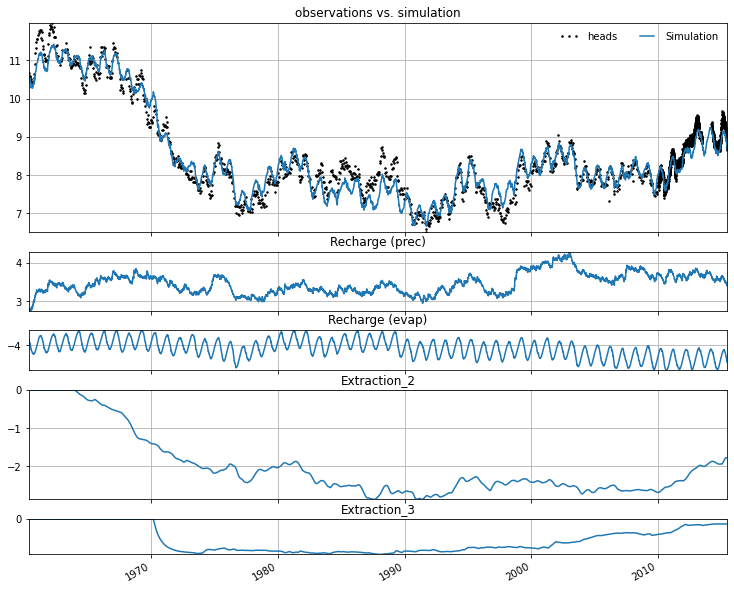

In [11]:
ml.plots.decomposition();

We can calculate the gain of each extraction (quantified as the effect on the groundwater level of a continuous extraction of ~1 Mm$^3$/yr).

In [12]:
for i in range(len(extraction_names)):
    name = extraction_names[i]
    sm = ml.stressmodels[name]
    p = ml.get_parameters(name)
    gain = sm.rfunc.gain(p) * 1e6 / 365.25
    print(f"{name}: gain = {gain:.3f} m / Mm^3/year")
    df.at[name, 'gain StressModel'] = gain

Extraction_2: gain = -0.281 m / Mm^3/year
Extraction_3: gain = -0.122 m / Mm^3/year


## Create a model with a WellModel
We can reduce the number of parameters in the model by including the three extractions in a WellModel. This WellModel takes into account the distances from the three extractions to the observation well, and assumes constant geohydrological properties. All of the extractions now share the same response function, scaled by the distance between the extraction well and the observation well.

First we create a new model and add recharge.

In [13]:
ml_wm = ps.Model(oseries, oseries.name + "_wm")
rm = ps.RechargeModel(prec, evap, ps.Gamma, 'Recharge')
ml_wm.add_stressmodel(rm)

INFO: Inferred frequency for time series prec: freq=D
INFO: Inferred frequency for time series evap: freq=D


We have all the information we need to create a WellModel:
- timeseries for each of the extractions, these are passed as a list of stresses
- distances from each extraction to the observation point, note that the order of these distances must correspond to the order of the stresses.

Note: the WellModel only works with a special version of the Hantush response function called `HantushWellModel`. This is because the response function must support scaling by a distance $r$. The HantushWellModel response function has been modified to support this. The Hantush response normally takes three parameters: the gain $A$, $a$ and $b$. This special version accepts 4 parameters: it interprets that fourth parameter as the distance $r$, and uses it to scale the parameters accordingly. 

Create the WellModel and add to the model.

In [14]:
w = ps.WellModel(stresses, ps.HantushWellModel, "Wells", distances, settings="well")
ml_wm.add_stressmodel(w)

Solve the model. 

We are once again using `ps.LmfitSolve`. The user is notified about the preference for this solver in a `WARNING` when creating the WellModel (see above). 

As we can see, the fit with the measurements (EVP) is similar to the result with the previous model, with each well included separately.

In [15]:
ml_wm.solve(solver=ps.LmfitSolve)

INFO: Time Series Extraction_3 was extended to 1950-05-01 00:00:00 by adding 0.0 values.
INFO: There are observations between the simulation timesteps. Linear interpolation between simulated values is used.


Fit report heads                        Fit Statistics
nfev    201                    EVP           93.40
nobs    2844                   R2             0.93
noise   1                      RMSE           0.23
tmin    1960-04-28 12:00:00    AIC         9428.01
tmax    2015-06-29 09:00:00    BIC         9481.58
freq    D                      Obj           23.07
warmup  3650 days 00:00:00     ___                
solver  LmfitSolve             Interp.         Yes

Parameters (9 optimized)
                  optimal   stderr       initial  vary
Recharge_A   1.341500e+03  ±18.30%  2.104985e+02  True
Recharge_n   9.985778e-01   ±3.66%  1.000000e+00  True
Recharge_a   8.874334e+02  ±29.54%  1.000000e+01  True
Recharge_f  -2.000000e+00  ±13.37% -1.000000e+00  True
Wells_A     -1.954441e-04  ±49.88% -7.559848e-04  True
Wells_a      7.123814e+02  ±36.59%  1.000000e+02  True
Wells_b      4.562667e-08  ±67.24%  1.558737e-07  True
constant_d   1.202862e+01   ±5.32%  8.557530e+00  True
noise_alpha  5.7

### Visualize the results
Plot the decomposition to see the individual influence of each of the wells

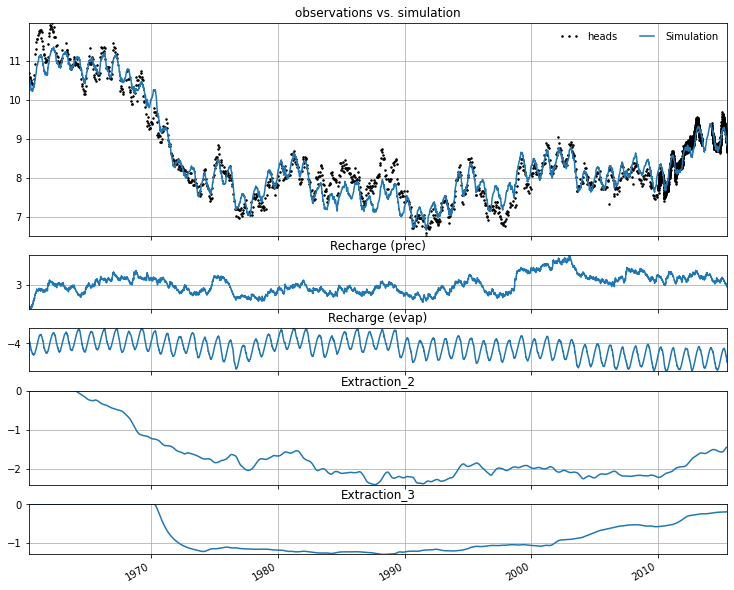

In [16]:
ml_wm.plots.decomposition();

Plot the stacked influence of each of the individual extraction wells in the results plot

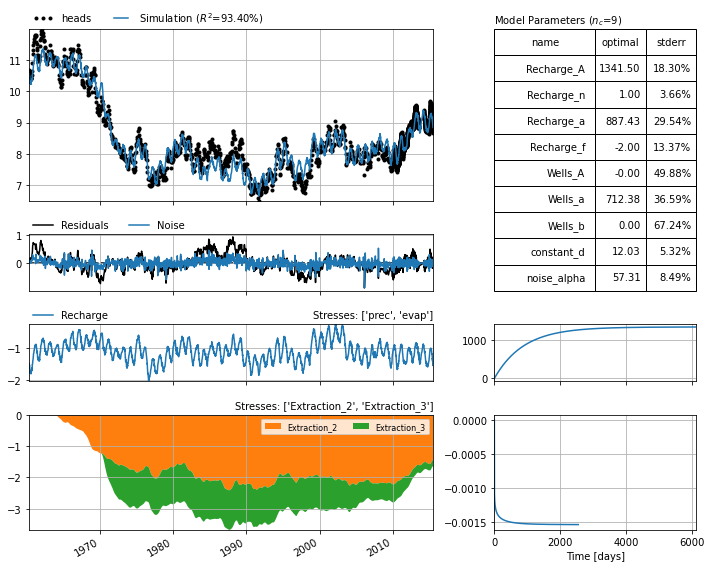

In [17]:
ml_wm.plots.stacked_results(figsize=(10, 8));

Get parameters for each well (including the distance) and calculate the gain. The WellModel reorders the stresses from closest to the observation well, to furthest from the observation well. We have take this into account during the post-processing.

The gain of extraction 1 is lower than the gain of extraction 2 and 3. This will always be the case in a WellModel when the distance from the observation well to extraction 1 is larger than the distance to extraction 2 and 3.

In [18]:
wm = ml_wm.stressmodels["Wells"]
for i in range(len(extraction_names)):
    # get parameters
    p = wm.get_parameters(model=ml_wm, istress=i)
    # calculate gain
    gain = wm.rfunc.gain(p) * 1e6 / 365.25
    name = wm.stress[i].name
    print(f"{name}: gain = {gain:.3f} m / Mm^3/year")
    df.at[name, 'gain WellModel'] = gain

Extraction_2: gain = -0.234 m / Mm^3/year
Extraction_3: gain = -0.173 m / Mm^3/year


## Compare individual StressModels and WellModel

Compare the gains that were calculated by the individual StressModels and the WellModel.

In [19]:
df.style.format("{:.4f}")

,Distance to observation well,gain StressModel,gain WellModel
Extraction_2,2281.9645,-0.2813,-0.2336
Extraction_3,2783.7834,-0.1220,-0.1730
